In [2]:
import numpy as np
import pandas as pd
import os
import time
import random 
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/submission.csv')
weather = pd.read_csv('data/weather_hour.csv', encoding = 'cp949')

# 1. 데이터 전처리

In [5]:
def seed(seed = 0) :
    random.seed(seed)
    np.random.seed(seed)

### '시드를 고정한다' 의 의미
* random함수를 사용하면 [0.0, 1.0]의 float값을 얻음 
* 이때 해당 값들은 seed에 따라 랜덤하게 발생
* 실험이나 기능 테스트를 위해 재현성이 필요할 때 시드를 고정하면 동일한 결과가 생성됨

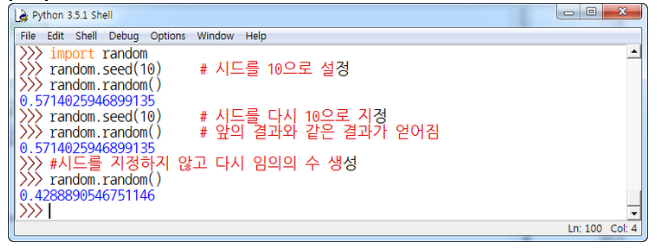

In [7]:
from IPython.display import Image
Image('Image/seed.png')

In [8]:
weather['일시'] = pd.to_datetime(weather['일시'])
weather = weather.iloc[ : , 1:3]
weather.columns = ['Time', 'temp']

* 기상데이터에서 1-2열, 일시와 온도 데이터만을 사용
* column명은 time, temp로 변경

* holiday는 한국의 공휴일들을 import하여 처리하려고 하였으나 본 코드에서는 제외

### 변수
* Time으로부터 생성하는 변수 : month, week, weekday, day, hour
* weekend를 이용하여 휴일을 정의
* 직전주차에 사용한 전력량의 std와 mean을 변수로 사용(only hour predict) -> 모델에 추세에 대한 정보를 부여하는 목적
* target 변수의 outlier를 제거하기 위해 평균을 기준으로 3sigma 외의 값들 clipping

### Case
* include temp and hour predict
* exclude temp and hour predict
* exclude temp and day, month predict

In [29]:
def merge(train, col, hour=True, use_temp=True):
    temp = train[['Time', col]].rename(columns={col:'target'})
    temp['Time'] = pd.to_datetime(temp['Time'])
    temp = temp[temp['Time'] >= '2017-11-23'].reset_index(drop=True)
    temp = temp.loc[temp.index[temp['target'].astype(str)!='nan'][0]:].reset_index(drop=True)

    temp['Time'] = pd.to_datetime(temp['Time'])
    temp['month'] = temp['Time'].dt.month
    temp['week'] = temp['Time'].dt.week
    temp['weekday'] = temp['Time'].dt.weekday
    temp['day'] = temp['Time'].dt.day
    temp['hour'] = temp['Time'].dt.hour
    temp['holiday'] = temp['Time'].dt.date.isin(holidays).astype(int)
    temp['weekend'] = temp['weekday'].map({0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:1})
    temp['is_holiday'] = (temp['weekend'] + temp['holiday']).map({0:0, 1:1, 2:1})
    temp['date'] = pd.to_datetime(temp['Time'].dt.date)
    temp['tomorrow'] = pd.to_datetime(temp['date']) + datetime.timedelta(days=1)

    for i in range(24):
        temp.loc[temp['hour']==i, 'target'] = temp.loc[temp['hour']==i, 'target'].clip(0, temp.loc[temp['hour']==i, 'target'].mean() + 3*temp.loc[temp['hour']==i, 'target'].std())

    if hour:
        temp2 = pd.DataFrame(pd.date_range('20180701', '20181201', freq='h'), columns=['Time']).iloc[:24, :]
    else:
        temp2 = pd.DataFrame(pd.date_range('20180701', '20181201', freq='h'), columns=['Time']).iloc[:-1]
    temp2['Time'] = pd.to_datetime(temp2['Time'])
    temp2['month'] = temp2['Time'].dt.month
    temp2['week'] = temp2['Time'].dt.week
    temp2['weekday'] = temp2['Time'].dt.weekday
    temp2['day'] = temp2['Time'].dt.day
    temp2['hour'] = temp2['Time'].dt.hour
    temp2['holiday'] = temp2['Time'].dt.date.isin(holidays).astype(int)
    temp2['weekend'] = temp2['weekday'].map({0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:1})
    temp2['is_holiday'] = (temp2['weekend'] + temp2['holiday']).map({0:0, 1:1, 2:1})
    temp2['date'] = pd.to_datetime(temp2['Time'].dt.date)
    temp2['tomorrow'] = pd.to_datetime(temp2['date']) + datetime.timedelta(days=1)


    if hour:
        temp['next_week'] = temp['week']+1
        temp2['next_week'] = temp2['week']+1

        temp_dict = temp.groupby('next_week')['target'].mean()
        temp['next_week_mean'] = temp['week'].map(temp_dict)
        temp2['next_week_mean'] = temp2['week'].map(temp_dict)
        temp_dict = temp.groupby('next_week')['target'].std()
        temp['next_week_std'] = temp['week'].map(temp_dict)
        temp2['next_week_std'] = temp2['week'].map(temp_dict)

        if use_temp:
            temp = pd.merge(temp, weather, how='left', on='Time')
            temp2 = pd.merge(temp2, weather, how='left', on='Time')

        return temp.dropna().reset_index(drop=True), temp2
    else:
        return temp.dropna().reset_index(drop=True), temp2

* &gt; 의 의미 : > 인데 python2에서는 >가 바로 지원이 안되서 저렇게 쓴 듯.
* python3에서는 >, < 연산자가 지원이 되서 모두 수정해줌.

* &lt; stands for the less-than sign ( < )
* &gt; stands for the greater-than sign ( > )
* &le; stands for the less-than or equals sign ( ≤ )
* &ge; stands for the greater-than or equals sign ( ≥ )

* df.drop_index(drop = True)의 의미
* 데이터 프레임 좌측에는 0, 1, 2,... 로 진행되는 index가 존재.
* 사용자 설정에 따라 인덱스를 임의의 column으로 대체할수도 있음.
* reset_index를 진행하면 임의의 column으로 되어있는 index를 다시 0, 1, 2...으로 대체
* 이때 drop = True이면 기존의 index였던 column은 필요없다고 판단하고 삭제

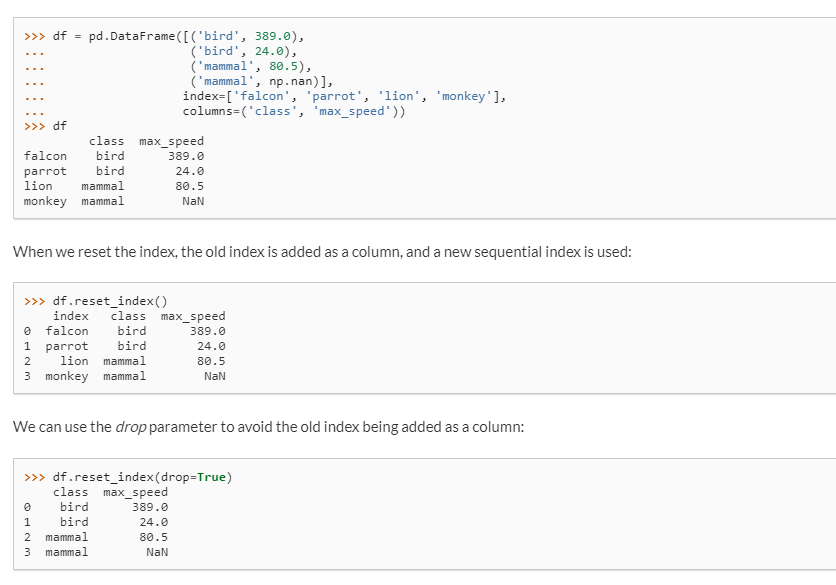

In [31]:
Image('image/drop_index.png')

# 2. 탐색적 자료분석

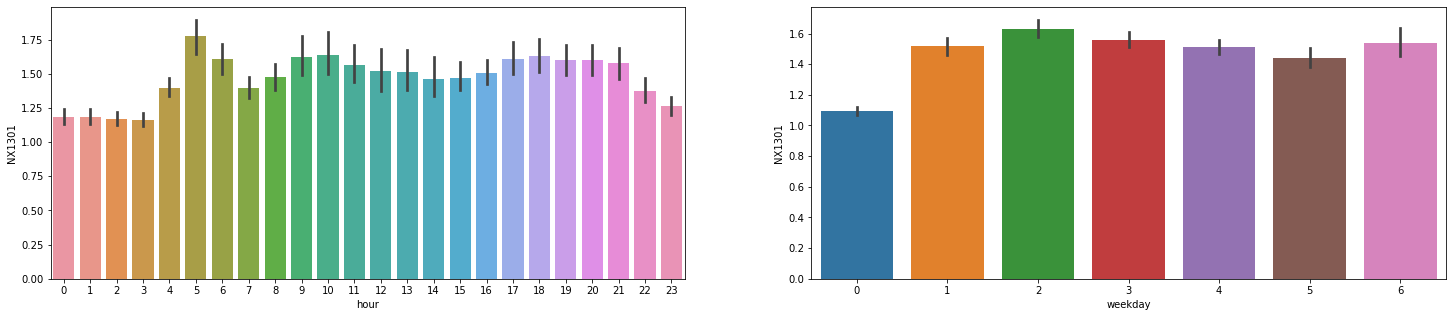

In [24]:
plt.subplots(1, 2, figsize=(25, 5))

plt.subplot(1, 2, 1)
temp_df = test[['Time', 'NX1301']].dropna()
temp_df['hour'] = pd.to_datetime(temp_df['Time']).dt.hour
sns.barplot(x='hour', y='NX1301', data=temp_df)

plt.subplot(1, 2, 2)
temp_df = test[['Time', 'NX1301']].dropna()
temp_df['weekday'] = pd.to_datetime(temp_df['Time']).dt.weekday
sns.barplot(x='weekday', y='NX1301', data=temp_df)
plt.show()

* .dt.hour : pandas time series 데이터에서 시간만을 추출하는 함수
* .dt.weekday : pandas time series 데이터에서 주중 날짜(월화수목금토일을 각각 0-6으로 mapping)만을 추출하는 함수

# 3. 변수 선택 및 모델 구축 

### Feature Engineering & Initial Modeling
* 각각의 모델을 만듬으로서 총 200개의 모델 생성
* 베이스모델은 xgboost로 시작
* 속도가 느렸기 때문에, lightgbm으로 변환(성능의 상승) -> xgboost의 경우 overfit의 문제가 있었을 것이라 추정
* kfold, loocv, validation subset 구축 등의 모든 방법이 cv==lb가 맞지 않는 경우 발생
* LB를 기준으로 파라미터 조절을 수행
* 보다 robust한 모델을 구축하기 위해, smape metrics 에서 weight가 강한 hour 예측 모델은 온도 포함/온도 미포함 결과를 앙상블하고 시드앙상블 수행
* 결론적으로 시드앙상블을 안한 모델이 private score가 좋았습니다.

In [30]:
from collections import defaultdict

submit_dict = defaultdict()
lgb_params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metric':'rmse',
        'n_jobs':-1,
        'learning_rate':0.03,
        'num_leaves': 2**9,
        'max_depth':-1,
        'tree_learner':'serial',
        'min_child_weight':5, 
        'subsample':0.7,
        'reg_alpha':0.2,
        'reg_lambda':0.2,
        'verbose':-1,
        'seed': 0
    }

for idx in tqdm.tqdm_notebook(list(range(200))):
    hours=True
    using_temp=True
    train_df, test_df = merge(test, sub['meter_id'][idx], hour=hours, use_temp=using_temp)
    glo_pred1 = np.zeros(len(test_df))
    
    for SEED in [42, 43, 44, 45, 46]:
        lgb_params['seed'] = SEED
        pred1 = np.zeros(len(test_df))
        
        feature = [i for i in train_df.columns if i not in ['Time', 'target', 'holiday', 'weekend', 'date', 'tomorrow', 'next_week']]
        kf = KFold(n_splits=5, random_state=SEED, shuffle=True)

        for trn_idx, val_idx in kf.split(train_df):
            tt = lgb.Dataset(train_df.loc[trn_idx, feature], train_df.loc[trn_idx, ['target']])
            vv = lgb.Dataset(train_df.loc[val_idx, feature], train_df.loc[val_idx, ['target']])
            model = lgb.train(lgb_params, tt, 100, valid_sets=[tt, vv], early_stopping_rounds=50, verbose_eval=0)
            pred1 += model.predict(test_df[feature])/5
        pred1[pred1&lt==0] = train_df['target'].min()
        glo_pred1 += pred1/5
        
    using_temp=False
    train_df, test_df = merge(test, sub['meter_id'][idx], hour=hours, use_temp=using_temp)
    glo_pred2 = np.zeros(len(test_df))
    
    for SEED in [42, 43, 44, 45, 46]:
        lgb_params['seed'] = SEED
        pred2 = np.zeros(len(test_df))
    
        feature = [i for i in train_df.columns if i not in ['Time', 'target', 'holiday', 'weekend', 'date', 'tomorrow', 'next_week']]
        kf = KFold(n_splits=5, random_state=SEED, shuffle=True)

        for trn_idx, val_idx in kf.split(train_df):
            tt = lgb.Dataset(train_df.loc[trn_idx, feature], train_df.loc[trn_idx, ['target']])
            vv = lgb.Dataset(train_df.loc[val_idx, feature], train_df.loc[val_idx, ['target']])
            model = lgb.train(lgb_params, tt, 200, valid_sets=[tt, vv], early_stopping_rounds=50, verbose_eval=0)
            pred2 += model.predict(test_df[feature])/5
        pred2[pred2&lt==0] = train_df['target'].min()
        glo_pred2 += pred2/5
    submit_dict[idx] = glo_pred1*0.6 + glo_pred2*0.4
    
submit_df = pd.DataFrame(submit_dict)
submit_df.columns = sub['meter_id']
submit_df = submit_df.T.reset_index()
submit_df.columns = sub.columns[:25]
submit_df_hour = submit_df.copy()

C:\Users\kumih\Anaconda3\envs\injo\lib\site-packages\ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


NameError: name 'holidays' is not defined